__SHAP (SHapley Additive exPlanations)__ is a game theoretic approach to explain the output of any machine learning model. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions.

__Explainable AI with Shapley values__

Shapley values are a widely used approach from cooperative game theory that come with desirable properties. This tutorial is designed to help build a solid understanding of how to compute and interpet Shapley-based explanations of machine learning models.

In [2]:
import shap
import pandas as pd
import sklearn

_Explaining Linear Regression Model_

One of the simplest model types is standard linear regression, and so below we train a linear regression model on the classic boston housing dataset. 

In [3]:
X, y = shap.datasets.boston()
X_samp = shap.utils.sample(X,100)

# a simple linear model

model = sklearn.linear_model.LinearRegression()
model.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [7]:
X.shape , y.shape

((506, 13), (506,))

In [10]:
X.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT'],
      dtype='object')

The most common way of understanding a linear model is to examine the coefficients learned for each feature. These coefficients tell us how much the model output changes when we change each of the input features

CRIM - per capita crime rate by town  
ZN - proportion of residential land zoned for lots over 25,000 sq.ft.  
INDUS - proportion of non-retail business acres per town.  
CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)  
NOX - nitric oxides concentration (parts per 10 million)  
RM - average number of rooms per dwelling  
AGE - proportion of owner-occupied units built prior to 1940  
DIS - weighted distances to five Boston employment centres  
RAD - index of accessibility to radial highways  
TAX - full-value property-tax rate per $10000    
PTRATIO - pupil-teacher ratio by town      
B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town      
LSTAT - lower status of the population        
MEDV - Median value of owner-occupied homes in $1000’s

In [4]:
print("Model coefficients:\n")
for i in range(X.shape[1]):
    print(X.columns[i], "=", model.coef_[i].round(4))

Model coefficients:

CRIM = -0.108
ZN = 0.0464
INDUS = 0.0206
CHAS = 2.6867
NOX = -17.7666
RM = 3.8099
AGE = 0.0007
DIS = -1.4756
RAD = 0.306
TAX = -0.0123
PTRATIO = -0.9527
B = 0.0093
LSTAT = -0.5248


While coefficents are great for telling us what will happen when we change the value of an input feature, by themselves they are not a great way to measure the _overall importance of a feature_

To understand a feature’s importance in a model it is necessary to understand both how changing that feature impacts the model’s output, and also the distribution of that feature’s values.
To visualize this for a linear model we can build a classical partial dependence plot and show the distribution of feature values as a histogram on the x-axis:

_For 'DIS' - weighted distance to five boston employment centers_

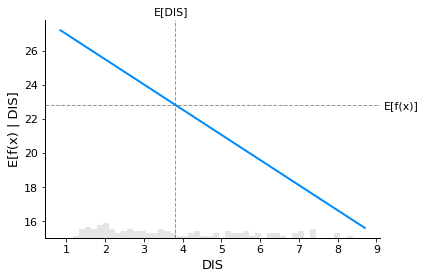

In [5]:
shap.plots.partial_dependence("DIS", model.predict, X_samp, ice= False, model_expected_value= True , feature_expected_value= True)

For 'RM' - average number of rooms per dwelling 

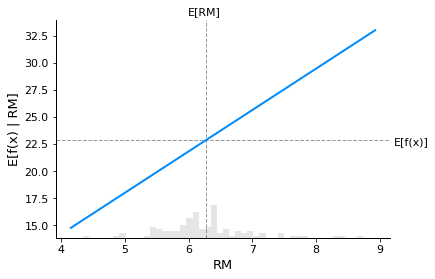

In [11]:
shap.plots.partial_dependence("RM", model.predict, X_samp, ice= False, model_expected_value= True , feature_expected_value= True)

The gray horizontal line in the plot above represents the expected value of the model when applied to the boston housing dataset. The vertical gray line represents the average value of the feature. Note that the blue partial dependence plot line (which the is average value of the model output when we fix the feature to a given value) always passes through the interesection of the two gray expected value lines.

__Reading the Shapley values from PDP__

The core idea behind Shapley value based explanations of machine learning models is to use fair allocation results from cooperative game theory to __allocate credit for a model’s output 𝑓(𝑥) among its input features.__  
In order to connect game theory with machine learning models it is nessecary to both match a model’s input features with players in a game, and also match the model function with the rules of the game. Since in game theory a player can join or not join a game, we need a way for a feature to “join” or “not join” a model.  
The most common way to define what it means for a feature to “join” a model is to say that feature has “joined a model” _when we know the value of that feature_, and it has not joined a model _when we don’t know the value of that feature_

In [12]:
# compute the SHAP values for the model

background = shap.maskers.Independent(X , max_samples= 1000)
explainer = shap.Explainer(model.predict, background)
shap_values = explainer(X)

Permutation explainer: 507it [00:14, 34.70it/s]                         


In [14]:
shap_values.shape

(506, 13)

In [16]:
shap_values[18]

.values =
array([ 3.03599789e-01, -5.27505209e-01, -6.16096527e-02, -1.85841272e-01,
        2.96614628e-01, -3.15698532e+00, -2.21338145e-02, -2.15036164e-03,
       -1.69839316e+00,  1.24871919e+00, -2.42423332e+00, -6.30252265e-01,
        5.05375504e-01])

.base_values =
22.532806324110666

.data =
array([  0.80271,   0.     ,   8.14   ,   0.     ,   0.538  ,   5.456  ,
        36.6    ,   3.7965 ,   4.     , 307.     ,  21.     , 288.99   ,
        11.69   ])

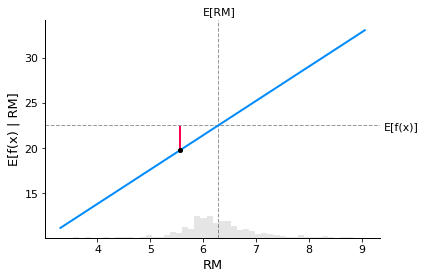

In [28]:
# make a standard partial dependence plot
sample_ind = 20
fig,ax = shap.partial_dependence_plot(
    "RM", model.predict, X, model_expected_value=True,
    feature_expected_value=True, show=False, ice=False,
    shap_values=shap_values[sample_ind:sample_ind+1,:],
    shap_value_features=X.iloc[sample_ind:sample_ind+1,:]
)



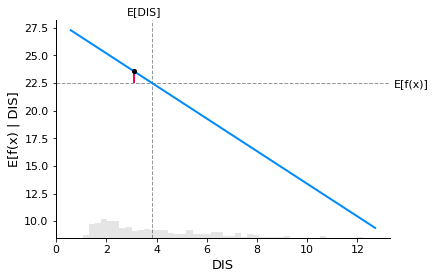

In [22]:
# make a standard partial dependence plot
sample_ind = 90
fig,ax = shap.partial_dependence_plot(
    "DIS", model.predict, X, model_expected_value=True,
    feature_expected_value=True, show=False, ice=False,
    shap_values=shap_values[sample_ind:sample_ind+1,:],
    shap_value_features=X.iloc[sample_ind:sample_ind+1,:]
)


The close correspondence between the classic partial dependence plot and SHAP values means that if we plot the SHAP value for a specific feature across a whole dataset we will exactly trace out a mean centered version of the partial dependence plot for that feature

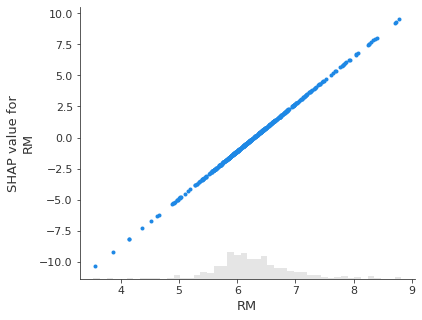

In [29]:
shap.plots.scatter(shap_values[:,"RM"])

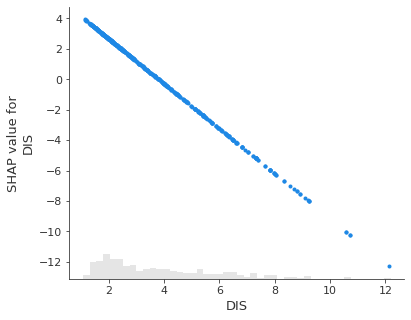

In [30]:
shap.plots.scatter(shap_values[:,"DIS"])

__The additive nature of Shapley values__

One the fundemental properties of Shapley values is that they always sum up to the difference between the game outcome when all players are present and the game outcome when no players are present.   
For machine learning models this means that SHAP values of all the input features will always sum up to the difference between baseline (expected) model output and the current model output for the prediction being explained.

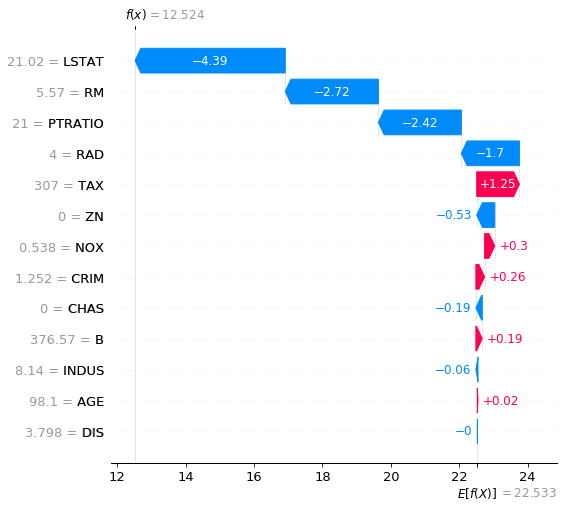

In [31]:
# the waterfall_plot shows how we get from shap_values.base_values to model.predict(X)[sample_ind]
shap.plots.waterfall(shap_values[sample_ind], max_display=14)